/projects/cc/se_users/carlsson_ksmq649/miniconda3/envs/aizynthmodels/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/cc/se_users/carlsson_ksmq649/miniconda3/envs/aizynthmodels/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


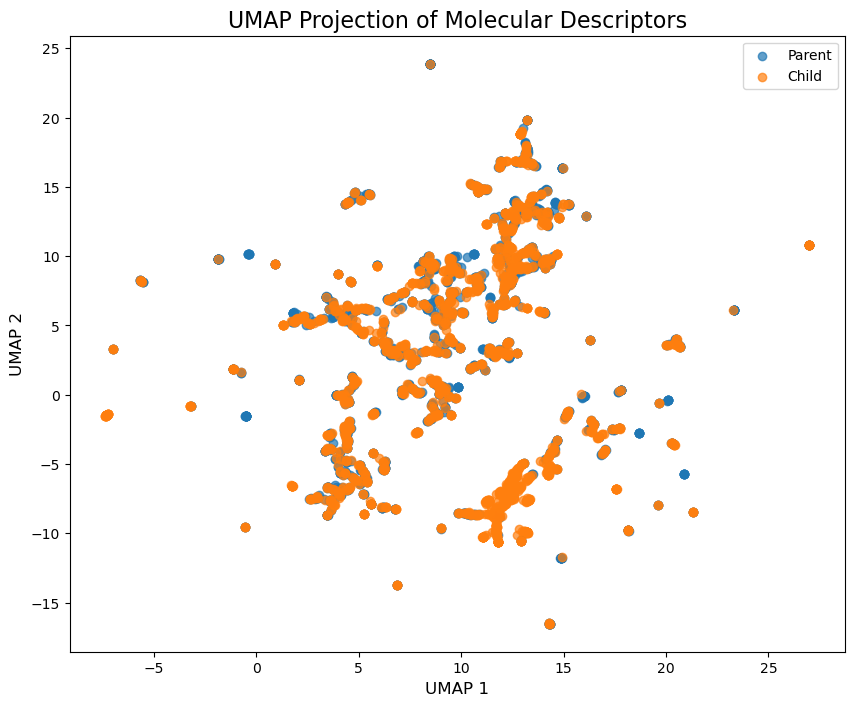

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Lipinski, Crippen
import umap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def calculate_descriptors(smiles_list):
    data = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            # Handle cases where SMILES cannot be parsed.
            continue

        descriptors = {
            "Chiral": len(Chem.FindMolChiralCenters(mol, includeUnassigned=True)),
            "MolWt": round(Descriptors.MolWt(mol), 3),
            "HeavyAtoms": Lipinski.HeavyAtomCount(mol),
            "HAcceptors": Lipinski.NumHAcceptors(mol),
            "HDonors": Lipinski.NumHDonors(mol),
            "LogP": round(Crippen.MolLogP(mol), 3),
            "TPSA": round(Descriptors.TPSA(mol), 3),
            "AromaticAtoms": sum([1 for atom in mol.GetAtoms() if atom.GetIsAromatic()]),
            "FormalCharge": sum([atom.GetFormalCharge() for atom in mol.GetAtoms()]),
            "NumRings": rdMolDescriptors.CalcNumRings(mol),
            "FractionCSP3": round(Descriptors.FractionCSP3(mol), 3),
            "Halogens": Chem.Fragments.fr_halogen(mol),
            "MR": round(Crippen.MolMR(mol), 3),
            # Element-specific atom counts (e.g., N, O) can be added similarly
            "NumN": sum([1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 7]),
            "NumO": sum([1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 8]),
        }
        data.append(descriptors)
    return pd.DataFrame(data)

def visualize_with_umap(csv):
 
    df = pd.read_csv(csv)
    parent_smiles = df["parent_smiles"]
    child_smiles = df["child_smiles"]

    parent_descriptors = calculate_descriptors(parent_smiles)
    child_descriptors = calculate_descriptors(child_smiles)

    # Combine the descriptors for UMAP
    combined_data = pd.concat([parent_descriptors, child_descriptors], keys=['Parent', 'Child'])

    # Standardize the data for better UMAP performance
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(combined_data)

    # Initialize and fit UMAP
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    embedding = reducer.fit_transform(scaled_data)

    # Plot the UMAP
    plt.figure(figsize=(10, 8))
    plt.scatter(embedding[:len(parent_descriptors), 0], embedding[:len(parent_descriptors), 1], label='Parent', alpha=0.7)
    plt.scatter(embedding[len(parent_descriptors):, 0], embedding[len(parent_descriptors):, 1], label='Child', alpha=0.7)
    plt.title('UMAP Projection of Molecular Descriptors', fontsize=16)
    plt.xlabel('UMAP 1', fontsize=12)
    plt.ylabel('UMAP 2', fontsize=12)
    plt.legend()
    plt.show()

# Example call to the function
data_file = '/projects/cc/se_users/carlsson_ksmq649/MasterThesis/dataset/curated_data/metxbiodb_smiles_clean.csv'
visualize_with_umap(data_file)